In [1]:
import warnings
warnings.filterwarnings('ignore')

# load task scores

In [2]:
import pandas as pd

In [3]:
dfb = pd.read_csv('/Users/qasem/PycharmProjects/grad_ecc_RL_data/RL_behavior.csv')  # df behaviour

In [4]:
dfb.head()

,Subject,Block,Trial,Score,ReactionTime,MovementTime,Valid
0,AB1,1,1,53.0,0.365009,0.182444,True
1,AB1,1,2,51.0,0.548555,0.402011,True
2,AB1,1,3,7.0,0.472627,0.269147,True
3,AB1,1,4,0.0,0.557651,0.289636,True
4,AB1,1,5,34.0,0.588884,0.211777,True


## create metrics
### calculate t-test as metric

In [5]:
import pingouin as pg

In [6]:
def ttest_init_final(df_subj):
    df_subj = df_subj[df_subj.Trial.notna()]
    # iloc[:n] takes first n rows, not till index n
    x, y = df_subj.iloc[:20]['Score'], df_subj.iloc[-20:]['Score']
    return pg.ttest(x, y, paired=False, alternative='less').iloc[0,0]

### fPCA score

In [7]:
fpca_scores = pd.read_csv('data/RLfpcaScores.csv').set_index('Subject')
metrics = dfb[dfb.Block==2].groupby('Subject').apply(ttest_init_final)
metrics = metrics.rename('tscore').to_frame().join(fpca_scores, how='inner')

In [8]:
metrics

,tscore,RLScore
Subject,,
AB1,-8.686500,-1.179789
AG1,-6.485268,1.104018
AH1,-2.347640,-0.302101
AM1,-6.676496,-1.400917
AP1,-16.480796,0.868475
AV1,-3.902501,0.859943
BN1,-6.263557,1.433999
CD1,-10.370127,-0.661215
CG1,-4.442353,-0.337563


In [9]:
match = pd.read_csv('/Users/qasem/PycharmProjects/gradients-rl-task/data/participants.tsv', delimiter='\t')
# match.columns = ['subject', 'Subject', 'exclude']
# match = match.set_index('Subject')['subject']
# match
# metrics.join(match)#.to_csv('data/metrics.csv', index=True)

In [10]:
import seaborn as sns

correlation between metrics

<AxesSubplot:xlabel='tscore', ylabel='RLScore'>

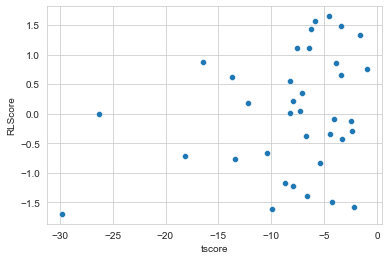

In [11]:
sns.scatterplot(data=metrics, x='tscore', y='RLScore')

## load features
gradients

In [12]:
dfg = pd.read_csv('data/gradients.csv')  # df gradient values
dfg

,subject,epoch,region,7net,17net,g1,g2,g3,g4,ecc
0,1,baseline,7Networks_LH_Vis_1,Vis,DorsAttnA,0.516958,-0.186538,1.501042,-0.668984,1.732833
1,1,baseline,7Networks_LH_Vis_2,Vis,VisCent,0.636391,1.407541,0.977047,-0.758676,1.978984
2,1,baseline,7Networks_LH_Vis_3,Vis,DorsAttnA,0.396966,0.630318,1.806822,0.007569,1.954366
3,1,baseline,7Networks_LH_Vis_4,Vis,VisCent,2.380421,2.049884,0.085447,-0.858037,3.257601
4,1,baseline,7Networks_LH_Vis_5,Vis,DefaultC,0.408135,0.698659,0.977117,0.278002,1.298746
...,...,...,...,...,...,...,...,...,...,...
109291,46,late,Right Putamen,Striatum,StriatumRight,-0.861413,-0.664291,-0.450307,-1.694324,2.063208
109292,46,late,Right Pallidum,Striatum,StriatumRight,-0.530126,-0.774942,-0.468807,-1.149747,1.556685
109293,46,late,Right Hippocampus,Striatum,StriatumRight,-0.938860,-0.247830,-1.223909,-1.464685,2.141526
109294,46,late,Right Amygdala,Striatum,StriatumRight,-1.114832,-0.355354,-1.374354,-1.242685,2.191402


In [13]:
dff = pd.merge(dfg, match,
               left_on='subject', right_on='participant_id', how='inner') # df features
dff = dff.rename(columns={'dicom_dir': 'Subject'})
dff = dff.set_index(['subject', 'Subject', 'epoch', 'region', '7net', '17net'])[['ecc']].unstack('epoch')   # make epochs differentiable
dff = dff.droplevel(level=0, axis=1)

In [14]:
dff['b2e'] = dff['early'] - dff['baseline']
dff['e2l'] = dff['late'] - dff['early']
dff = dff.reorder_levels([2, 3, 4, 0, 1])
dff.head()

,,,,epoch,baseline,early,late,b2e,e2l
region,7net,17net,subject,Subject,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716


In [15]:
df = dff.reset_index(level=[0,1,2,3]).join(metrics)  # metrics and features merged
df = df.set_index(['region', '7net', '17net', 'subject', df.index])

In [16]:
df.head()

,,,,,baseline,early,late,b2e,e2l,tscore,RLScore
region,7net,17net,subject,Subject,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603,-8.6865,-1.179789
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927,-8.6865,-1.179789
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721,-8.6865,-1.179789
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659,-8.6865,-1.179789
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716,-8.6865,-1.179789


# cross correlation

In [17]:
from scipy.stats import pearsonr

In [18]:
def r_value(data, x, y):   return pearsonr(data[x], data[y])[0]
def p_value(data, x, y):   return pearsonr(data[x], data[y])[1]

<AxesSubplot:xlabel='b2e', ylabel='tscore'>

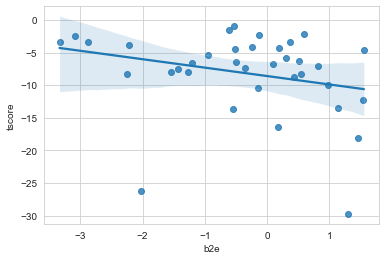

In [19]:
sns.regplot(data=df.loc['7Networks_LH_Default_PFC_9'], x='b2e', y='tscore')

## on each region

In [20]:
df.head()

,,,,,baseline,early,late,b2e,e2l,tscore,RLScore
region,7net,17net,subject,Subject,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603,-8.6865,-1.179789
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927,-8.6865,-1.179789
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721,-8.6865,-1.179789
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659,-8.6865,-1.179789
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716,-8.6865,-1.179789


In [21]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore', 'tscore']
l0=[]
for y in Y:
    l1=[]
    for x in X:
        r = df.groupby(level=0).apply(r_value, x=x, y=y)    # grouped by region
        p = df.groupby(level=0).apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfcr = pd.concat(l0, axis=1, keys=Y)    # cross correlation

In [22]:
dfcr['RLScore']['baseline']['r'].head()

region
7Networks_LH_Cont_Cing_1    0.166323
7Networks_LH_Cont_Cing_2   -0.094146
7Networks_LH_Cont_Cing_3    0.030368
7Networks_LH_Cont_Cing_4    0.169644
7Networks_LH_Cont_Cing_5    0.422829
Name: r, dtype: float64

significant regions out of 1012 regions

In [24]:
p = dfcr.xs('p', axis=1, level=2)
(p<.05).sum().unstack()

,baseline,early,late,b2e,e2l
RLScore,33,61,34,51,54
tscore,109,74,59,94,29


In [26]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [27]:
region_names = pd.read_csv('data/regions_sorted.csv')['region']

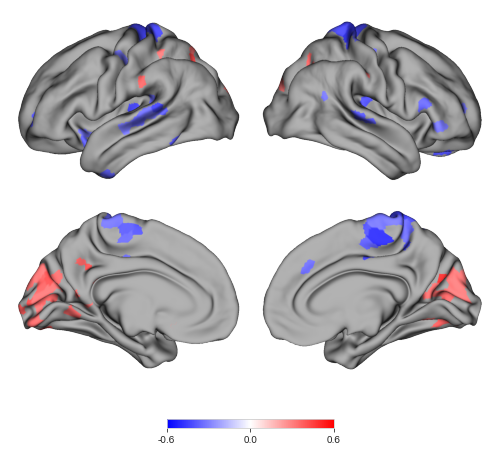

In [33]:
data = dfcr['tscore']['baseline']
data = data.apply(lambda row: row['r'] if row['p']<.05 else None, axis=1)
data = data.loc[region_names]
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-.6,.6))
_ = p.build()

## 7 network
average features within networks

In [25]:
df.head()

,,,,,baseline,early,late,b2e,e2l,tscore,RLScore
region,7net,17net,subject,Subject,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603,-7.195868,-1.179789
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927,-7.195868,-1.179789
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721,-7.195868,-1.179789
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659,-7.195868,-1.179789
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716,-7.195868,-1.179789


In [34]:
# level 1 is for 7 network - level 2 is for 17 network
dfn7 = df.groupby(level=[1,3,4]).mean()  # df networks mean

In [35]:
dfn7.head()

baseline     early      late       b2e       e2l  \
7net subject Subject                                                     
Cont 1       AB1      2.693424  2.542259  3.139027 -0.151165  0.596768   
     2       AG1      2.768695  2.797363  2.977104  0.028667  0.179741   
     3       AH1      2.733566  2.748539  2.646460  0.014973 -0.102079   
     4       AM1      2.495153  2.723009  3.000811  0.227856  0.277802   
     6       AP1      2.688645  3.074856  2.737626  0.386211 -0.337231   

                         tscore   RLScore  
7net subject Subject                       
Cont 1       AB1      -8.686500 -1.179789  
     2       AG1      -6.485268  1.104018  
     3       AH1      -2.347640 -0.302101  
     4       AM1      -6.676496 -1.400917  
     6       AP1     -16.480796  0.868475

In [27]:
# dfn7.xs('JS1', level=2)
# dfn7.dropna(inplace=True)

In [28]:
dfn7.loc['Limbic']

,,baseline,early,late,b2e,e2l,tscore,RLScore
subject,Subject,,,,,,,
1,AB1,1.753462,2.622839,2.591867,0.869377,-0.030973,-7.195868,-1.179789
2,AG1,1.974920,1.847991,2.242053,-0.126929,0.394062,-5.822339,1.104018
3,AH1,2.049521,2.064206,1.766884,0.014684,-0.297322,-2.248812,-0.302101
4,AM1,2.168872,2.295605,1.933349,0.126733,-0.362256,-6.593196,-1.400917
6,AP1,2.684421,2.228505,2.131638,-0.455917,-0.096867,-15.539946,0.868475
7,AV1,2.185039,1.728208,2.191345,-0.456831,0.463138,-4.009663,0.859943
8,BN1,2.496586,2.185391,2.361804,-0.311196,0.176413,-6.426085,1.433999
9,CD1,1.803491,1.786990,2.422435,-0.016501,0.635445,-11.893333,-0.661215
10,CG1,2.359467,2.057391,2.270541,-0.302076,0.213150,-3.318209,-0.337563


<AxesSubplot: xlabel='b2e', ylabel='RLScore'>

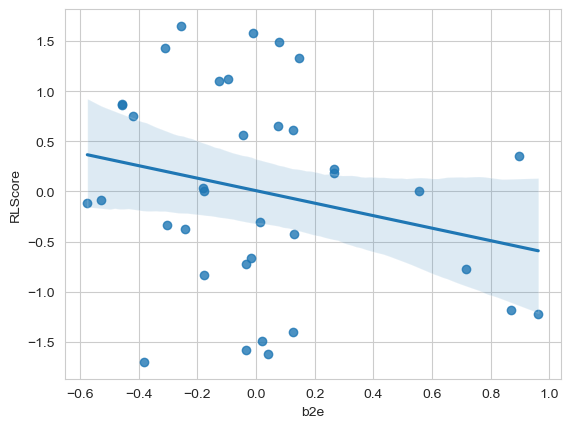

In [29]:
sns.regplot(data=dfn7.loc['Limbic'], x='b2e', y='RLScore')

In [37]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore', 'tscore']
l0=[]
for y in Y:
    l1=[]
    for x in X:
        r = dfn7.groupby(level=0).apply(r_value, x=x, y=y)    # grouped by region
        p = dfn7.groupby(level=0).apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfc7 = pd.concat(l0, axis=1, keys=Y)    # cross correlation

In [41]:
dfc7

RLScore                                                    \
             baseline                         early                       
                    r         p      pcor         r         p      pcor   
7net                                                                      
Cont         0.027112  0.875275  0.977552  0.037280  0.829095  0.829095   
Default     -0.046152  0.789254  0.977552 -0.151587  0.377485  0.522782   
DorsAttn     0.295405  0.080265  0.537996 -0.152432  0.374802  0.522782   
Limbic       0.074318  0.666638  0.977552 -0.221485  0.194217  0.522782   
SalVentAttn  0.254286  0.134499  0.537996 -0.196671  0.250288  0.522782   
SomMot      -0.004861  0.977552  0.977552 -0.127849  0.457434  0.522782   
Striatum    -0.014671  0.932320  0.977552 -0.135512  0.430684  0.522782   
Vis          0.136755  0.426428  0.977552 -0.289218  0.087109  0.522782   

                                                     ...    tscore            \
                 late                           b2e  ...     early      late   
                    r         p      pcor         r  ...      pcor         r   
7net                                                 ...                       
Cont        -0.056316  0.744248  0.820147  0.003651  ...  0.833626 -0.050687   
Default      0.039264  0.820147  0.820147 -0.091733  ...  0.833626 -0.107700   
DorsAttn    -0.050453  0.770120  0.820147 -0.308878  ...  0.833626 -0.168742   
Limbic       0.088776  0.606641  0.820147 -0.242433  ...  0.177954 -0.073216   
SalVentAttn -0.134383  0.434568  0.820147 -0.278413  ...  0.833626 -0.160794   
SomMot      -0.163158  0.341711  0.820147 -0.075985  ...  0.833626  0.132900   
Striatum    -0.252251  0.137752  0.820147 -0.074945  ...  0.833626 -0.281707   
Vis          0.216031  0.205711  0.820147 -0.252723  ...  0.177954 -0.038355   

                                                                         \
                                      b2e                           e2l   
                    p      pcor         r         p      pcor         r   
7net                                                                      
Cont         0.769080  0.824244  0.113457  0.509991  0.815986 -0.052335   
Default      0.531830  0.824244 -0.001351  0.993762  0.993762 -0.037008   
DorsAttn     0.325215  0.824244 -0.187129  0.274464  0.663704 -0.072462   
Limbic       0.671300  0.824244 -0.166475  0.331852  0.663704  0.201442   
SalVentAttn  0.348846  0.824244 -0.009574  0.955807  0.993762 -0.070722   
SomMot       0.439703  0.824244  0.184191  0.282205  0.663704  0.174357   
Striatum     0.096014  0.768109 -0.059988  0.728185  0.970914 -0.112480   
Vis          0.824244  0.824244 -0.391901  0.018086  0.144687  0.197883   

                                 
                                 
                    p      pcor  
7net                             
Cont         0.761787  0.830326  
Default      0.830326  0.830326  
DorsAttn     0.674498  0.830326  
Limbic       0.238748  0.824360  
SalVentAttn  0.681901  0.830326  
SomMot       0.309135  0.824360  
Striatum     0.513667  0.830326  
Vis          0.247322  0.824360  

[8 rows x 30 columns]

In [43]:
p = dfc7.xs('p', axis=1, level=2)
(p<.05).sum().unstack()

,baseline,early,late,b2e,e2l
RLScore,0,0,0,0,0
tscore,1,2,0,1,0


<AxesSubplot:ylabel='7net'>

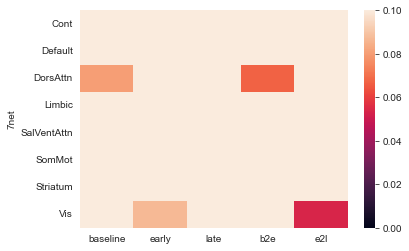

In [48]:
sns.heatmap(dfc7['RLScore'].xs('p', axis=1, level=1), vmin=0, vmax=.1)

<AxesSubplot:ylabel='7net'>

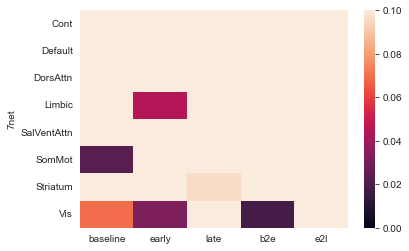

In [49]:
sns.heatmap(dfc7['tscore'].xs('p', axis=1, level=1), vmin=0, vmax=.1)

## 17 network

In [50]:
# level 1 is for 7 network - level 2 is for 17 network
dfn17 = df.groupby(level=[2,3,4]).mean()  # df networks mean
dfn17.head()

baseline     early      late       b2e       e2l  \
17net subject Subject                                                     
ContA 1       AB1      2.295317  2.586899  2.927281  0.291582  0.340382   
      2       AG1      2.734415  2.881234  2.921745  0.146819  0.040510   
      3       AH1      3.163622  2.661075  2.481281 -0.502547 -0.179794   
      4       AM1      2.500188  2.655211  2.849887  0.155024  0.194676   
      6       AP1      2.802678  3.022130  2.813918  0.219452 -0.208212   

                          tscore   RLScore  
17net subject Subject                       
ContA 1       AB1      -8.686500 -1.179789  
      2       AG1      -6.485268  1.104018  
      3       AH1      -2.347640 -0.302101  
      4       AM1      -6.676496 -1.400917  
      6       AP1     -16.480796  0.868475

In [35]:
dfn17.loc['DorsAttnA']

,,baseline,early,late,b2e,e2l,tscore,RLScore
subject,Subject,,,,,,,
1,AB1,2.506013,3.561924,3.433465,1.055910,-0.128458,-7.195868,-1.179789
2,AG1,3.486623,3.077975,3.070569,-0.408648,-0.007406,-5.822339,1.104018
3,AH1,3.320220,3.023186,2.848300,-0.297034,-0.174886,-2.248812,-0.302101
4,AM1,3.236016,3.374225,2.757671,0.138208,-0.616554,-6.593196,-1.400917
6,AP1,3.099582,3.009507,2.893724,-0.090075,-0.115783,-15.539946,0.868475
7,AV1,3.004278,3.452615,2.564821,0.448337,-0.887794,-4.009663,0.859943
8,BN1,3.155521,2.823218,3.868180,-0.332303,1.044963,-6.426085,1.433999
9,CD1,2.689726,3.182209,3.240891,0.492482,0.058682,-11.893333,-0.661215
10,CG1,3.072255,3.263234,3.342977,0.190979,0.079743,-3.318209,-0.337563


<AxesSubplot: xlabel='b2e', ylabel='RLScore'>

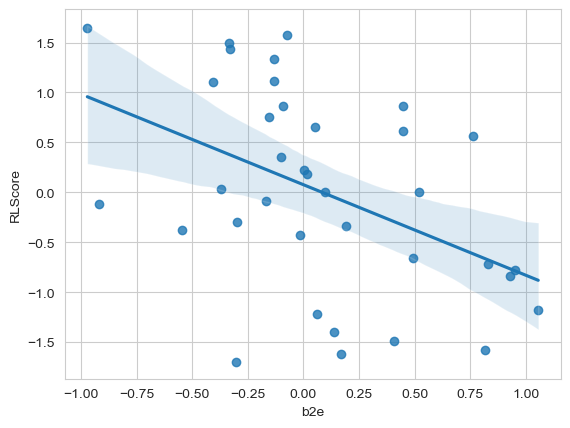

In [36]:
sns.regplot(data=dfn17.loc['DorsAttnA'], x='b2e', y='RLScore')

In [51]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore', 'tscore']
l0=[]
for y in Y:
    l1=[]
    for x in X:
        r = dfn17.groupby(level=0).apply(r_value, x=x, y=y)    # grouped by region
        p = dfn17.groupby(level=0).apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfc17 = pd.concat(l0, axis=1, keys=Y)    # cross correlation

In [52]:
dfc17

RLScore                                                    \
               baseline                         early                       
                      r         p      pcor         r         p      pcor   
17net                                                                       
ContA          0.242422  0.154288  0.829181  0.137614  0.423502  0.670544   
ContB         -0.109831  0.523693  0.829181  0.053711  0.755711  0.844618   
ContC         -0.193306  0.258646  0.829181 -0.233268  0.170941  0.670544   
DefaultA      -0.071501  0.678584  0.920936 -0.161892  0.345519  0.670544   
DefaultB       0.059165  0.731777  0.926918 -0.080667  0.640011  0.810681   
DefaultC      -0.011683  0.946084  0.986628 -0.229685  0.177796  0.670544   
DorsAttnA      0.252912  0.136689  0.829181 -0.456676  0.005114  0.097173   
DorsAttnB      0.121241  0.481198  0.829181 -0.055471  0.747963  0.844618   
LimbicA        0.032224  0.851999  0.986570 -0.193746  0.257542  0.670544   
LimbicB        0.096684  0.574833  0.840141 -0.140201  0.414754  0.670544   
SalVentAttnA   0.262242  0.122321  0.829181 -0.161318  0.347255  0.670544   
SalVentAttnB   0.211218  0.216239  0.829181 -0.032315  0.851587  0.851587   
SomMotA       -0.183033  0.285296  0.829181 -0.032317  0.851574  0.851587   
SomMotB        0.158345  0.356331  0.829181 -0.188087  0.271971  0.670544   
StriatumLeft  -0.002895  0.986628  0.986628 -0.148715  0.386694  0.670544   
StriatumRight -0.025482  0.882721  0.986570 -0.115169  0.503587  0.725143   
TempPar        0.116208  0.499719  0.829181 -0.107052  0.534316  0.725143   
VisCent        0.161951  0.345341  0.829181 -0.300751  0.074693  0.670544   
VisPeri        0.114379  0.506536  0.829181 -0.168158  0.326915  0.670544   

                                                       ...    tscore  \
                   late                           b2e  ...     early   
                      r         p      pcor         r  ...      pcor   
17net                                                  ...             
ContA         -0.196148  0.251575  0.646616 -0.084964  ...  0.819247   
ContB          0.002455  0.988662  0.988662  0.111271  ...  0.928187   
ContC          0.188244  0.271564  0.646616  0.018215  ...  0.888385   
DefaultA       0.013985  0.935482  0.988662 -0.063962  ...  0.998553   
DefaultB      -0.007330  0.966155  0.988662 -0.091162  ...  0.819247   
DefaultC       0.110062  0.522813  0.903041 -0.124971  ...  0.705393   
DorsAttnA      0.083951  0.626408  0.988662 -0.450562  ...  0.705393   
DorsAttnB     -0.046809  0.786319  0.988662 -0.119707  ...  0.819247   
LimbicA        0.198323  0.246250  0.646616 -0.167592  ...  0.705393   
LimbicB       -0.056176  0.744864  0.988662 -0.213777  ...  0.482931   
SalVentAttnA  -0.175369  0.306292  0.646616 -0.262747  ...  0.822297   
SalVentAttnB  -0.111709  0.516576  0.903041 -0.184596  ...  0.819247   
SomMotA       -0.217270  0.203060  0.646616  0.095483  ...  0.819247   
SomMotB       -0.038584  0.823211  0.988662 -0.210589  ...  0.705393   
StriatumLeft  -0.183815  0.283206  0.646616 -0.093722  ...  0.819247   
StriatumRight -0.306276  0.069257  0.646616 -0.054654  ...  0.705393   
TempPar        0.018966  0.912576  0.988662 -0.154012  ...  0.705393   
VisCent        0.186025  0.277358  0.646616 -0.263635  ...  0.482931   
VisPeri        0.206005  0.228054  0.646616 -0.178135  ...  0.506022   

                                                                           \
                   late                           b2e                       
                      r         p      pcor         r         p      pcor   
17net                                                                       
ContA         -0.173856  0.310549  0.871509  0.015151  0.930111  0.930111   
ContB         -0.057390  0.739539  0.936749  0.190983  0.264523  0.558437   
ContC          0.008717  0.959760  0.970241 -0.037625  0.827539  0.930111   
DefaultA      -0.082784  0.631226  0.871509 -0.0

In [54]:
p = dfc17.xs('p', axis=1, level=2)
(p<.05).sum().unstack()

,baseline,early,late,b2e,e2l
RLScore,0,1,0,1,1
tscore,3,1,0,2,0


<AxesSubplot:ylabel='17net'>

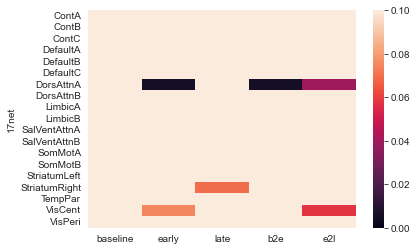

In [56]:
sns.heatmap(dfc17['RLScore'].xs('p', axis=1, level=1), vmin=0, vmax=.1)

<AxesSubplot:ylabel='17net'>

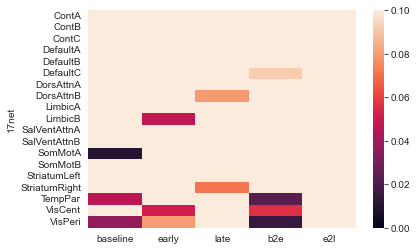

In [57]:
sns.heatmap(dfc17['tscore'].xs('p', axis=1, level=1), vmin=0, vmax=.1)

# permutation test

In [58]:
from pingouin import distance_corr

In [59]:
def perm_pvalue(df, feature, metric):   return distance_corr(df[feature], df[metric])[1]

## regoins

In [60]:
df.head()

,,,,,baseline,early,late,b2e,e2l,tscore,RLScore
region,7net,17net,subject,Subject,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.579930,2.510811,3.351414,0.930881,0.840603,-8.6865,-1.179789
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.881808,3.327869,1.732942,0.446061,-1.594927,-8.6865,-1.179789
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.869047,3.241946,2.264225,0.372899,-0.977721,-8.6865,-1.179789
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.842360,2.098228,2.278887,1.255868,0.180659,-8.6865,-1.179789
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.641586,2.067705,2.066989,0.426119,-0.000716,-8.6865,-1.179789


In [44]:
df.loc['7Networks_LH_Cont_Cing_1']

baseline     early      late       b2e  \
7net 17net        subject Subject                                           
Cont SalVentAttnB 1       AB1      1.579930  2.510811  3.351414  0.930881   
                  2       AG1      3.517658  3.823488  2.389208  0.305830   
                  3       AH1      2.335139  1.983248  1.571522 -0.351890   
                  4       AM1      1.927699  2.389032  2.718790  0.461333   
                  6       AP1      1.844896  2.818948  0.990385  0.974052   
                  7       AV1      3.536721  1.781280  1.582131 -1.755441   
                  8       BN1      1.685159  1.928411  2.518372  0.243252   
                  9       CD1      2.541401  1.605992  2.408289 -0.935409   
                  10      CG1      2.163047  2.149965  3.746296 -0.013082   
                  11      CH1      1.920260  2.552032  3.042574  0.631771   
                  12      CK1      1.660527  2.284115  4.494268  0.623588   
                  13      CM1      2.084163  1.595539  1.799677 -0.488624   
                  14      CM2      2.787100  2.914182  2.982514  0.127082   
                  15      CS1      2.535155  1.833316  3.181236 -0.701839   
                  16      EH1      1.813324  4.646819  2.806612  2.833496   
                  17      EK1      2.345408  2.941076  3.190370  0.595667   
                  18      HK1      2.660456  2.234464  3.030312 -0.425993   
                  19      HS1      2.316271  2.818323  2.346968  0.502053   
                  20      JC1      2.287415  1.833660  3.830116 -0.453756   
                  21      JH1      2.379764  3.137212  3.495661  0.757448   
                  23      JM1      2.969953  1.433003  1.684791 -1.536950   
                  24      JR1      2.556985  2.086329  1.500293 -0.470656   
                  26      KK1      2.248285  3.395986  0.675521  1.147700   
                  28      KP1      1.181847  3.983517  2.878301  2.801671   
                  29      KR1      2.927040  2.623971  2.806905 -0.303068   
                  30      LB1      2.764953  2.052787  3.031407 -0.712166   
                  31      MB1      0.910315  4.251804  2.656542  3.341489   
                  32      MG1      1.903308  2.077636  2.300513  0.174329   
                  33      MP1      2.257331  1.197777  3.522655 -1.059554   
                  35      NW1      2.042179  1.965599  1.478230 -0.076581   
                  38      SK1      2.589592  1.151595  3.515735 -1.437997   
                  40      SM2      2.036498  3.180592  0.716461  1.144094   
                  41      SR1      3.260708  1.704357  2.868869 -1.556351   
                  44      UP1      3.093398  2.032582  1.658464 -1.060816   
                  45      WK1      4.005707  3.082868  2.473592 -0.922838   
                  46      ZN1      2.303472  2.509474  3.201352  0.206002   

                                        e2l     tscore   RLScore  
7net 17net        subject Subject                                 
Cont SalVentAttnB 1       AB1      0.840603  -7.195868 -1.179789  
                  2       AG1     -1.434280  -5.822339  1.104018  
                  3       AH1     -0.411727  -2.248812 -0.302101  
                  4       AM1      0.329758  -6.593196 -1.400917  
                  6       AP1     -1.828563 -15.539946  0.868475  
                  7       AV1     -0.199149  -4.009663  0.859943  
                  8       BN1      0.589961  -6.426085  1.433999  
                  9       CD1      0.802297 -11.893333 -0.661215  
                  10      CG1      1.596331  -3.318209 -0.337563  
                  11      CH1      0.490543  -3.573430 -0.088406  
                  12      CK1      2.210153 -18.086867 -0.719677  
                  13      CM1      0.204138  -7.138170  0.220940  
                  14      CM2      0.068332  -4.033090  1.491491  
                  15      CS1      1.347920 -29.750010 -1.698549  
                  16      EH1     -1

In [61]:
perm_pvalue(df.loc['7Networks_LH_Cont_Cing_1'], 'baseline', 'RLScore')

0.314

In [63]:
# df.groupby(level=0).apply(perm_pvalue, feature='baseline', metric='tscore')

In [65]:
from tqdm import tqdm
tqdm.pandas()

In [66]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore', 'tscore']
l0=[]
for y in Y:
    l1=[]
    for x in tqdm(X):
        p = df.groupby(level=0).apply(perm_pvalue, feature=x, metric=y) # grouped by region
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([p, pcorr], axis=1, keys=['p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfperm = pd.concat(l0, axis=1, keys=Y)    # cross correlation

100%|██████████| 5/5 [03:55<00:00, 47.18s/it]


In [81]:
# dfperm.T.to_csv('data/permutation_regions.csv')

# dfperm = pd.read_csv('data/permutation_regions.csv')
# dfperm = dfperm.set_index(dfperm.columns.tolist()[:3]).T

Unnamed: 0                RLScore                                              \
Unnamed: 1               baseline            early             late             
Unnamed: 2                      p      pcor      p      pcor      p      pcor   
7Networks_LH_Cont_Cing_1    0.299  0.994744  0.265  0.927958  0.184  0.996759   
7Networks_LH_Cont_Cing_2    0.481  0.994744  0.104  0.843333  0.133  0.996759   
7Networks_LH_Cont_Cing_3    0.716  0.994744  0.336  0.938115  0.075  0.996759   
7Networks_LH_Cont_Cing_4    0.305  0.994744  0.491  0.939714  0.916  0.996759   
7Networks_LH_Cont_Cing_5    0.008  0.899556  0.174  0.889930  0.101  0.996759   
...                           ...       ...    ...       ...    ...       ...   
Right Caudate               0.187  0.994744  0.408  0.938115  0.030  0.996759   
Right Hippocampus           0.994  0.996955  0.702  0.939714  0.182  0.996759   
Right Pallidum              0.585  0.994744  0.964  0.990424  0.053  0.996759   
Right Putamen               0.388  0.994744  0.762  0.940420  0.969  0.996759   
Right Thalamus              0.079  0.994744  0.800  0.946179  0.614  0.996759   

Unnamed: 0                                                   tscore            \
Unnamed: 1                  b2e              e2l           baseline             
Unnamed: 2                    p      pcor      p      pcor        p      pcor   
7Networks_LH_Cont_Cing_1  0.764  0.977639  0.090  0.838063    0.850  0.952602   
7Networks_LH_Cont_Cing_2  0.225  0.977639  0.041  0.838063    0.763  0.918140   
7Networks_LH_Cont_Cing_3  0.284  0.977639  0.089  0.838063    0.728  0.907310   
7Networks_LH_Cont_Cing_4  0.552  0.977639  0.607  0.998974    0.262  0.672954   
7Networks_LH_Cont_Cing_5  0.028  0.873098  0.054  0.838063    0.703  0.906557   
...                         ...       ...    ...       ...      ...       ...   
Right Caudate             0.093  0.977639  0.439  0.998974    0.868  0.961068   
Right Hippocampus         0.902  0.984999  0.895  0.998974    0.371  0.755437   
Right Pallidum            0.860  0.977639  0.277  0.998974    0.629  0.887794   
Right Putamen             0.643  0.977639  0.609  0.998974    0.441  0.793520   
Right Thalamus            0.261  0.977639  0.319  0.998974    0.101  0.518714   

Unnamed: 0                                                                   \
Unnamed: 1                early             late              b2e             
Unnamed: 2                    p      pcor      p      pcor      p      pcor   
7Networks_LH_Cont_Cing_1  0.997  0.998974  0.142  0.941987  0.862  0.969554   
7Networks_LH_Cont_Cing_2  0.772  0.957698  0.389  0.986968  0.484  0.833007   
7Networks_LH_Cont_Cing_3  0.469  0.933713  0.981  1.000000  0.407  0.817681   
7Networks_LH_Cont_Cing_4  0.358  0.925111  0.243  0.986968  0.904  0.984766   
7Networks_LH_Cont_Cing_5  0.407  0.928791  0.504  0.986968  0.373  0.816593   
...                         ...       ...    ...       ...    ...       ...   
Right Caudate             0.920  0.978511  0.815  0.986968  0.955  0.997379   
Right Hippocampus         0.287  0.913346  0.462  0.986968  0.113  0.600080   
Right Pallidum            0.488  0.933713  0.022  0.849357  0.693  0.925333   
Right Putamen             0.362  0.925111  0.057  0.934154  0.586  0.863902   
Right Thalamus            0.984  0.991841  0.143  0.941987  0.177  0.667170   

Unnamed: 0                            
Unnamed: 1                  e2l       
Unnamed: 2                    p pcor  
7Networks_LH_Cont_Cing_1  0.421  1.0  
7Networks_LH_Cont_Cing_2  0.350  1.0  
7Networks_LH_Cont_Cing_3  0.621  1.0  
7Networks_LH_Cont_Cing_4  0.043  1.0  
7Networks_LH_Cont_Cing_5  0.448  1.0  
...                         ...  ...  
Right Caudate             0.928  1.0  
Right Hippocampus         0.917  1.0  
Right Pallidum            0.537  1.0  
Right Putamen             0.756  1.0  
Right Thalamus            0.393  1.0  

[1012 rows x 20 columns]

In [84]:
(dfperm.xs('p', level=2, axis=1) < .05).sum().unstack()

,baseline,early,late,b2e,e2l
RLScore,38,65,36,51,57
tscore,110,82,57,102,29


In [85]:
dfperm.head()

RLScore                                              \
                         baseline            early             late             
                                p      pcor      p      pcor      p      pcor   
region                                                                          
7Networks_LH_Cont_Cing_1    0.299  0.994744  0.265  0.927958  0.184  0.996759   
7Networks_LH_Cont_Cing_2    0.481  0.994744  0.104  0.843333  0.133  0.996759   
7Networks_LH_Cont_Cing_3    0.716  0.994744  0.336  0.938115  0.075  0.996759   
7Networks_LH_Cont_Cing_4    0.305  0.994744  0.491  0.939714  0.916  0.996759   
7Networks_LH_Cont_Cing_5    0.008  0.899556  0.174  0.889930  0.101  0.996759   

                                                             tscore            \
                            b2e              e2l           baseline             
                              p      pcor      p      pcor        p      pcor   
region                                                                          
7Networks_LH_Cont_Cing_1  0.764  0.977639  0.090  0.838063    0.850  0.952602   
7Networks_LH_Cont_Cing_2  0.225  0.977639  0.041  0.838063    0.763  0.918140   
7Networks_LH_Cont_Cing_3  0.284  0.977639  0.089  0.838063    0.728  0.907310   
7Networks_LH_Cont_Cing_4  0.552  0.977639  0.607  0.998974    0.262  0.672954   
7Networks_LH_Cont_Cing_5  0.028  0.873098  0.054  0.838063    0.703  0.906557   

                                                                             \
                          early             late              b2e             
                              p      pcor      p      pcor      p      pcor   
region                                                                        
7Networks_LH_Cont_Cing_1  0.997  0.998974  0.142  0.941987  0.862  0.969554   
7Networks_LH_Cont_Cing_2  0.772  0.957698  0.389  0.986968  0.484  0.833007   
7Networks_LH_Cont_Cing_3  0.469  0.933713  0.981  1.000000  0.407  0.817681   
7Networks_LH_Cont_Cing_4  0.358  0.925111  0.243  0.986968  0.904  0.984766   
7Networks_LH_Cont_Cing_5  0.407  0.928791  0.504  0.986968  0.373  0.816593   

                                      
                            e2l       
                              p pcor  
region                                
7Networks_LH_Cont_Cing_1  0.421  1.0  
7Networks_LH_Cont_Cing_2  0.350  1.0  
7Networks_LH_Cont_Cing_3  0.621  1.0  
7Networks_LH_Cont_Cing_4  0.043  1.0  
7Networks_LH_Cont_Cing_5  0.448  1.0

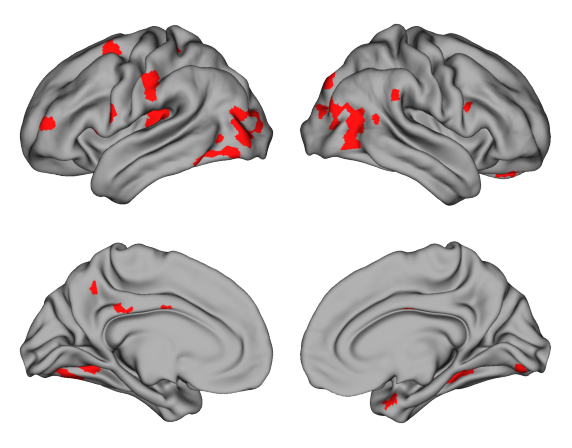

In [86]:
data = dfperm['RLScore']['early']
data = data.loc[region_names]
data = data['p'] < .05
data = data.loc[region_names]
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=False, cmap='bwr', color_range=(-1,1))
_ = p.build()

## 17 network

In [87]:
# level 1 is for 7 network - level 2 is for 17 network
dfn17 = df.groupby(level=[2, 3, 4]).mean()  # df networks mean

In [57]:
dfn17.loc['DorsAttnA']

,,baseline,early,late,b2e,e2l,tscore,RLScore
subject,Subject,,,,,,,
1,AB1,2.506013,3.561924,3.433465,1.055910,-0.128458,-7.195868,-1.179789
2,AG1,3.486623,3.077975,3.070569,-0.408648,-0.007406,-5.822339,1.104018
3,AH1,3.320220,3.023186,2.848300,-0.297034,-0.174886,-2.248812,-0.302101
4,AM1,3.236016,3.374225,2.757671,0.138208,-0.616554,-6.593196,-1.400917
6,AP1,3.099582,3.009507,2.893724,-0.090075,-0.115783,-15.539946,0.868475
7,AV1,3.004278,3.452615,2.564821,0.448337,-0.887794,-4.009663,0.859943
8,BN1,3.155521,2.823218,3.868180,-0.332303,1.044963,-6.426085,1.433999
9,CD1,2.689726,3.182209,3.240891,0.492482,0.058682,-11.893333,-0.661215
10,CG1,3.072255,3.263234,3.342977,0.190979,0.079743,-3.318209,-0.337563


In [88]:
# on 7 networks 'Cont' level 1
perm_pvalue(dfn17.loc['DorsAttnA'], feature='baseline', metric='tscore')

0.097

In [95]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore', 'tscore']
l0=[]
for y in Y:
    l1=[]
    for x in tqdm(X):
        p = dfn17.groupby(level=0).apply(perm_pvalue, feature=x, metric=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([p, pcorr], axis=1, keys=['p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfperm17 = pd.concat(l0, axis=1, keys=Y)    # cross correlation

100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


In [97]:
(dfperm17.xs('p', level=2, axis=1)<.05).sum().unstack()

,baseline,early,late,b2e,e2l
RLScore,1,2,0,1,1
tscore,2,3,0,3,0


<AxesSubplot:ylabel='17net'>

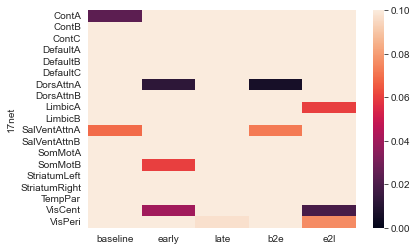

In [98]:
sns.heatmap(dfperm17['RLScore'].xs('p', axis=1, level=1), vmin=0, vmax=.1)

<AxesSubplot:ylabel='17net'>

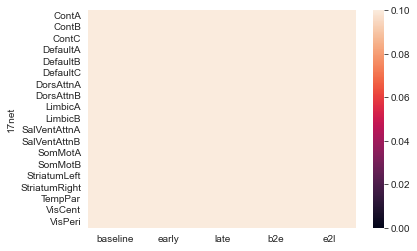

In [99]:
sns.heatmap(dfperm17['RLScore'].xs('pcor', axis=1, level=1), vmin=0, vmax=.1)

## 7 networks

In [102]:
# level 1 is for 7 network - level 2 is for 17 network
dfn7 = df.groupby(level=[1, 3, 4]).mean()  # df networks mean

In [103]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['RLScore', 'tscore']
l0=[]
for y in Y:
    l1=[]
    for x in tqdm(X):
        p = dfn7.groupby(level=0).apply(perm_pvalue, feature=x, metric=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([p, pcorr], axis=1, keys=['p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfperm7 = pd.concat(l0, axis=1, keys=Y)    # cross correlation

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


In [104]:
(dfperm7.xs('p', level=2, axis=1)<.05).sum().unstack()

,baseline,early,late,b2e,e2l
RLScore,2,1,0,0,1
tscore,1,1,0,1,0


<AxesSubplot:ylabel='7net'>

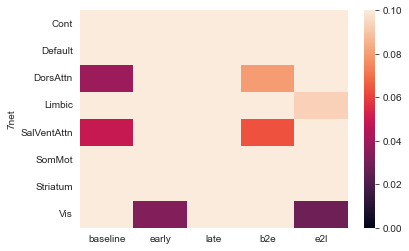

In [105]:
sns.heatmap(dfperm7['RLScore'].xs('p', axis=1, level=1), vmin=0, vmax=.1)

<AxesSubplot:ylabel='7net'>

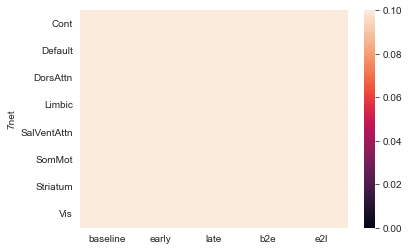

In [106]:
sns.heatmap(dfperm7['RLScore'].xs('pcor', axis=1, level=1), vmin=0, vmax=.1)